Dans l'exploration et la production de ressources fossiles, la caractérisation des faciès rocheux est essentielle pour l'estimation des propriétés physiques de la roche, telles que la porosité et la perméabilité, ainsi que pour la détection et la simulation des réservoirs.


En géologie, le terme de faciès (du latin qui signifie « aspect ») est un terme général qui est employé dans plusieurs champs de la discipline. Il a un intérêt descriptif et sert à qualifier un étage lithostratigraphique (une roche ou un minéral) ou biostratigraphique https://fr.wikipedia.org/wiki/Faci%C3%A8s_(g%C3%A9ologie).
 

La porosité est l'ensemble des vides (pores) d'un matériau solide, ces vides sont remplis par des fluides (liquide ou gaz). C'est une grandeur physique comprise entre 0 et 1 (ou, en pourcentage, entre 0 et 100 %), qui conditionne les capacités d'écoulement et de rétention d'un substrat https://fr.wikipedia.org/wiki/Porosit%C3%A9

La perméabilité d'un milieu poreux mesure son aptitude à se laisser traverser par un fluide sous l'effet d'un gradient de pression ou d'un champ de gravité. https://fr.wikipedia.org/wiki/Perm%C3%A9abilit%C3%A9_(fluide)

Je propose dans ce notebook un réseau de neurones convolutifs pour classer les Faciès.

Ce travail est basé sur l'article https://www.researchgate.net/publication/331991539_Characterizing_Rock_Facies_Using_Machine_Learning_Algorithm_Based_on_a_Convolutional_Neural_Network_and_Data_Padding_Strategy

In [1]:
import pandas as pd
import numpy as np


import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns;



from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix



import sklearn
import torchvision
import torchvision.transforms as transforms


from time import time

from imblearn.over_sampling import SMOTE,RandomOverSampler

from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
torch.manual_seed(42)


In [2]:
print(f'numpy version :{ np.__version__}')
print(f'pandas version :{ pd.__version__}')
print(f'torch version :{ torch.__version__}')
print(f'altair version :{ alt.__version__}')
print(f'seaborn version :{ sns.__version__}')
print(f'scikit learn version :{sklearn.__version__}')

numpy version :1.19.2
pandas version :1.1.3
torch version :1.7.1
altair version :4.1.0
seaborn version :0.11.0
scikit learn version :0.23.2


Les données peuvent être trouvées https://www.kaggle.com/imeintanis/well-log-facies-dataset.

In [3]:
df=pd.read_csv('facies_data.csv')

df=df.drop_duplicates()

In [4]:
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [5]:
df.shape

(3231, 11)

Nous avons 3231 rows et 11 variables.

Les variables caractéristiques comprennent cinq mesures et deux variables de contrainte géologique dérivées des connaissances géologiques.



Les sept variables sont:

1. GR: this wireline logging tools measure gamma emission
2. ILD_log10: this is resistivity measurement
3. PE: photoelectric effect log
4. DeltaPHI: Phi is a porosity index in petrophysics.
5. PNHIND: Average of neutron and density log.
6. NM_M:nonmarine-marine indicator
7. RELPOS: relative position

Les différentes classes de Faciès sont:

* SS: Nonmarine sandstone
* CSiS: Nonmarine coarse siltstone
* FSiS: Nonmarine fine siltstone
* SiSH: Marine siltstone and shale
* MS: Mudstone (limestone)
* WS: Wackestone (limestone)
* D: Dolomite
* PS: Packstone-grainstone (limestone)
* BS: Phylloid-algal bafflestone (limestone)


Les limites des faciès étant continues plutôt que discrètes, les propriétés mesurées pour différentes classes se chevauchent. Le tableau suivant liste les faciès, avec les faciès adjacents.

Un algorithme de classification fera peut être des erreurs, entre les facies et leurs adjacents.

In [6]:
Facies=range(1,10)
Facies_name=['SS','CSiS','FSiS','SiSh','MS','WS','D','PS','BS']
adjacent_facies = [[2], [1, 3], [2], [5], [4, 6], [5, 7], [6, 8], [6, 7, 9], [7, 8]]



df_adj=pd.DataFrame({'Facies':Facies,'Facies_Name':Facies_name,'adjacent_facies':adjacent_facies})

df_adj

,Facies,Facies_Name,adjacent_facies
0,1,SS,[2]
1,2,CSiS,"[1, 3]"
2,3,FSiS,[2]
3,4,SiSh,[5]
4,5,MS,"[4, 6]"
5,6,WS,"[5, 7]"
6,7,D,"[6, 8]"
7,8,PS,"[6, 7, 9]"
8,9,BS,"[7, 8]"


In [7]:
#One Hot Encoding de la variable catégorielle NM_M

df=pd.get_dummies(df,columns=['NM_M'],drop_first=True,prefix_sep='')

In [8]:
df.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,RELPOS,NM_M2
count,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000
mean,4.420922,2875.803466,66.083567,0.642759,3.559289,13.483855,3.724681,0.520325,0.498298
std,2.503839,131.021059,30.716527,0.241872,5.229719,7.700085,0.896091,0.286829,0.500074
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,0.010000,0.000000
25%,2.000000,2791.000000,46.914500,0.492500,1.162500,8.343500,3.100000,0.273000,0.000000
50%,4.000000,2893.500000,65.700000,0.624591,3.500000,12.150000,3.551000,0.526000,0.000000
75%,6.000000,2980.000000,79.625000,0.812823,6.436000,16.457500,4.300000,0.767500,1.000000
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,1.000000,1.000000


In [9]:
Facies_Name={1:'SS',2:'CSiS',3:'FSiS', 4:'SiSH',5:'MS',6:'WS',7:'D',8:'PS',9:'BS'}


facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

In [10]:
#J'ajoute les noms des faciès dans mon dataframe qui sont plus explicites

df['Facies_Name']=df.Facies.map(lambda v:Facies_Name[v])

In [11]:
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,RELPOS,NM_M2,Facies_Name
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1.000,0,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,0.979,0,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,0.957,0,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,0.936,0,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,0.915,0,FSiS


In [12]:
df.isnull().any()

Facies         False
Formation      False
Well Name      False
Depth          False
GR             False
ILD_log10      False
DeltaPHI       False
PHIND          False
PE             False
RELPOS         False
NM_M2          False
Facies_Name    False
dtype: bool

Il n'y a pas de valeurs manquantes dans nos données. Regardons à présent la distribution de nos classes.

In [13]:
alt.Chart(df).mark_bar().encode(
    x='count()',
    y='Facies_Name:N',
    color='Facies_Name:N'
        )

alt.Chart(...)

***Imbalanced Data***, les classes ne sont pas toutes bien représentées. La classe CSiS (Nonmarine coarse siltstone) est 7 fois beaucoup plus représentée que la classe D (dolomite). 

In [14]:
df.drop(['NM_M2','RELPOS','Facies'],axis=1).groupby('Well Name').mean()


,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE
Well Name,,,,,,
CHURCHMAN BIBLE,3019.482673,63.683453,0.758757,1.560000,14.011116,3.789926
CROSS H CATTLE,2702.360279,72.699285,0.568829,2.466667,15.574850,3.325852
LUKE G U,2725.708243,64.777223,0.639690,4.218438,12.953905,3.660705
NEWBY,2941.500000,60.733045,0.674812,3.477970,11.625378,3.771706
NOLAN,2957.000000,68.693940,0.592400,3.134070,12.197361,3.857947
Recruit F9,3038.367647,44.712853,0.567853,1.436515,13.183368,5.460735
SHANKLE,2890.502227,65.431180,0.630831,2.348998,15.741125,3.224944
SHRIMPLIN,2910.429787,69.057000,0.659987,7.714894,12.175330,4.218723


Dans le tableau ci-dessus, je regarde pour chaque wells la moyenne des variables mesurées, les moyennes sont un peu différentes d'un wells à l'autre.

In [15]:

def plot_Facies(data=df,Name='SHRIMPLIN',col_toDrop=['Formation','Well Name','RELPOS','NM_M2','Facies']):
    
    '''
    inputs: data: pandas dataframe
            Name: (string) name of well
            col_toDrop: columns to drop
            
    output:
            altair plot
    
    '''
    
    
    A=data[data['Well Name']==Name].drop(col_toDrop,axis=1).melt('Depth',var_name='Category',value_name='valeur')
    char1=alt.Chart(A).mark_line().transform_filter(
    alt.datum.Category!='Facies_Name').encode(
            x=alt.X('valeur:Q', scale=alt.Scale(zero=False), axis=alt.Axis(title=None)),
            y=alt.Y('Depth:Q',scale=alt.Scale(zero=False,reverse=True)),
            color=alt.Color('Category:N',legend=None),
            column='Category:N',
            order='index:Q'
    ).properties(height=400, width=50, title='Well: '+ Name).resolve_scale(x='independent')
    
    
    
    facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00','#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
    domain=['SS','CSiS','FSiS', 'SiSH','MS','WS','D','PS','BS']
    
    

    B=data[data['Well Name']==Name]
    char2=alt.Chart(B).mark_bar().encode(
          x=alt.X('count()',axis=alt.Axis(title=None,labels=False,grid=False)),
          y=alt.Y('Depth:Q',scale=alt.Scale(reverse=True), axis=alt.Axis(title=None,labels=False)),
          color=alt.Color('Facies_Name:N',scale=alt.Scale(domain=domain,range=facies_colors))
            ).properties(height=400, width=100)

    return alt.hconcat(char1,char2).resolve_scale(color='independent')

        
    

In [16]:
plot_Facies()

alt.HConcatChart(...)

Dans la figure ci-dessus, nous regardons l'évolution de nos variables mesurées et le type de faciès en fonction de la profondeur.

On pourrait visualiser d'autres WELLS et déterminer par exemple les faciès qu'on retrouve plus en profondeur.

In [17]:
plot_Facies(df[df['Well Name']=='Recruit F9'], Name='Recruit F9')

alt.HConcatChart(...)

In [18]:
df[df['Well Name']=='Recruit F9'].shape

(68, 12)

On peut voir que pour ce wells, les données sont différentes des autres, peut être que les données ne sont pas bonnes.
68 données sont concernées, on peut les enlever de notre étude.

In [19]:
df=df[df['Well Name']!='Recruit F9'].reset_index(drop=True)


print(df.shape)

(3163, 12)


Nous avons à présent 3163 rows.

In [20]:
corr=df.drop(['Depth','RELPOS','Facies','Formation','Well Name','NM_M2'],axis=1).corr()

corr=corr.reset_index().melt('index')
corr.columns=['var1','var2','correlation']
b=alt.Chart(corr).transform_filter(
    alt.datum.var1<alt.datum.var2).encode(
            x=alt.X('var1',axis=alt.Axis(title=None)),
            y=alt.Y('var2',axis=alt.Axis(title=None))
    ).properties(height=200,width=200)

rec=b.mark_rect().encode(
            color='correlation'
        )
text=b.mark_text().encode(
        text=alt.Text('correlation', format='.2f')
)

rec+text

alt.LayerChart(...)

<Figure size 576x432 with 0 Axes>

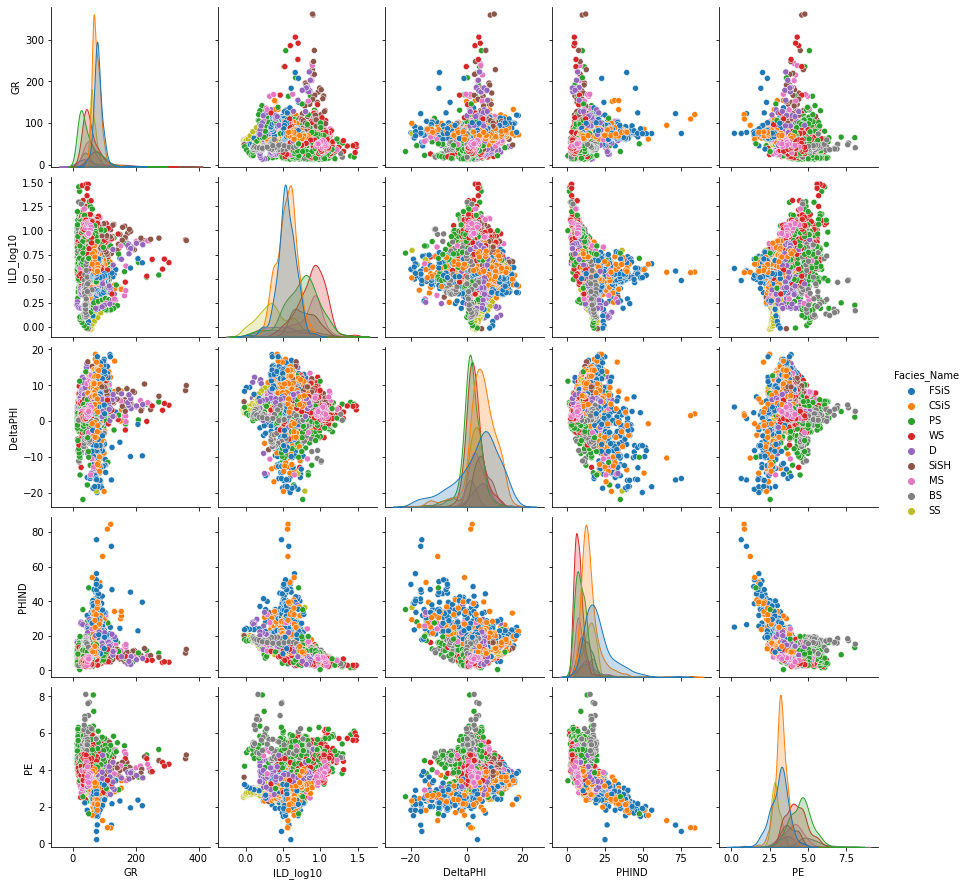

In [21]:
plt.figure(figsize=(8,6));

data=df.drop(['Depth','RELPOS','Facies','Formation','Well Name','NM_M2'],axis=1);
sns.pairplot(data, hue='Facies_Name');

Nos variables semblent avoir une relation complexe. Mais on peut remarquer une certaine tendance entre la variable PHIND (Average of neutron and density log) et la variable PE (photoelectric effect log).

In [22]:
WN=np.random.choice(df['Well Name'].unique(),3) #Je prends aléatoirement trois puits

CheckRelPE_PHIND=df[df['Well Name'].isin(WN)][['Well Name','PE','PHIND']]

scatter=alt.Chart(CheckRelPE_PHIND).mark_circle().encode(
                x='PE:Q',
                y='PHIND:Q').properties(height=200,width=200)


scatter = scatter + scatter.transform_regression('PE', 'PHIND').mark_line(
     color='red',
)



chart = scatter.facet(
    columns=3
    , facet=alt.Facet('Well Name',header=alt.Header(labelFontSize=25))
).resolve_scale(
    x='independent',
    y='independent'
)

chart.display()

alt.FacetChart(...)

J'ai pris aléatoirement trois puits (Wells)

La variable ***PE*** photoelectric effect log et la variable ***PHIND*** Average of neutron and density log semble avoir un certain lien linéaire.

A vérifier ?

Nous allons essayer de visualiser à présent les données dans le plan.

Pour cela, la procédure est la suivante:

* normalisation StandarScaler

* PCA  en gardant 95% de la variance

* TSNE manifold (pour visualiser dans le plan des données à grande dimension). https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html



In [23]:
df_train=df.drop(['Depth','Facies','Well Name','Facies_Name','Formation'],axis=1) #Je garde les colonnes qui m'intéressent
pipe=Pipeline([('scaler',StandardScaler()), ('acp', PCA(0.95)),('manifold',TSNE())])  # pipeline (les différentes procédures)
X_manifold=pipe.fit_transform(df_train)

In [24]:
#Visualisation interactive dans le plan Altair Viz

df_manifold=pd.DataFrame({'X1':X_manifold[:,0],'X2':X_manifold[:,1], 'Category':df['Facies_Name']})
brush = alt.selection(type='interval')
scatter=alt.Chart(df_manifold).mark_point(filled=True).encode(
        x=alt.X('X1:Q'),
        y=alt.Y('X2:Q'),
        color='Category:N'
        ).add_selection(brush)


hist=alt.Chart(df_manifold).mark_bar().encode(
        x='count()',
        y='Category:N',
        color='Category:N'
        ).transform_filter(brush)

alt.hconcat(scatter,hist)

alt.HConcatChart(...)

Cette visualisation est interactive, choisissez un intervalle, et vous avez la distribution des classes sur cet intervalle.

In [25]:
df[df['Facies_Name'].isin(['CSiS','FSiS','SS'])]['NM_M2'].value_counts()

0    1590
1      22
Name: NM_M2, dtype: int64

In [26]:
df[df['Facies_Name'].isin(['WS','SiSH','PS','MS','D'])]['NM_M2'].value_counts()

1    1427
0      31
Name: NM_M2, dtype: int64

On observe deux groupes (CSiS,FSiS,SS) et (WS,SiSH,PS,MS,D) qui correspondent aux non marines=0 et marines=1.

Un modèle de classification distinguera bien ces deux groupes mais aura du mal à l'intérieur d'un groupe.

### Modélisation Réseau de Neurones Convolutifs

Dans cette partie, je me base sur les travaux de cet article de recherche https://www.researchgate.net/publication/331991539_Characterizing_Rock_Facies_Using_Machine_Learning_Algorithm_Based_on_a_Convolutional_Neural_Network_and_Data_Padding_Strategy.

Pour passer d'une configuration 1D à une configuration 2D, les auteurs de cet article utilisent des stratégies qu'ils appellent padding.

3 formes de padding sont utilisées:

* equal padding
* shift padding
* random padding


Ils ont utilisés un réseau de neurones convolutionnels, et le shift padding semble mieux marcher dans leurs cas. Pour plus de détails, je vous invite à aller consulter l'article.

Le padding Shift joue comme le rôle du Random flip en traitement d'images.

J'utilise dans ce travail le shift padding.

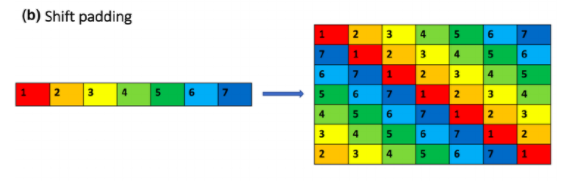

In [27]:
from IPython.display import Image

Image(filename = '/Users/cheikhtoure/Desktop/shiftPadding.png', width = 600, height = 300)

Ci_dessus est représenté à quoi représente le shift padding.


In [28]:
#Sous pytorch les labels vont de [0,...,n-1], donc je soustrais 1 à mes facies pour épouser la démarche de pytorch
df['IdxFacies']=df['Facies']-1

La procédure est la suivante pour les données d'entrainement:

* Normalisation https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html


* RandomOverSampling si sampling=True (Répéter quelques instances des classes sous représentées) https://imbalanced-learn.org/stable/generated/imblearn.over_sampling.RandomOverSampler.html



* Padding Shift décrit tout à l'heure


Pour les données test et validation:

* Normalisation

* Padding Shift

In [29]:
def shift(seq, n=0): 
    a = n % len(seq) 
    return np.array(seq[-a:]+seq[:-a])



def padding_shift(inp):
    '''
    Cette fonction prend en entrée, une liste et fait le shift padding dont 
    j'ai parlé tout à l'heure.
    
    '''
    tampon=inp*np.ones((len(inp),len(inp)))
    
    for i in range(len(tampon)):
        tampon[i,:]=shift(list(tampon[i,:]),n=i)
    return tampon  




def preproc_data(df, features=['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'NM_M2', 'RELPOS'],labels='IdxFacies',sampling=False):
    
    '''
    inputs:
            df: dataframe
            features: variable for training
            sampling (optional) default False :if True RandomOverSampling 
    outputs:
            Tensor Dataset
    
    
    '''
    
    if (df.name=='df_train') & (sampling):
        # RandomOverSampling (imbalanced class)
        preproc=StandardScaler().fit_transform(df[features])
        y=df['IdxFacies'].values
        preproc,y=RandomOverSampler(random_state=0).fit_resample(preproc,y)
        
        #padding shift
        preproc=torch.tensor([padding_shift(v) for v in preproc]).unsqueeze(1)
        y=torch.tensor(y).long()
        print(1)
        
        return TensorDataset(preproc,y)
        
        
        
    else:
        preproc=StandardScaler().fit_transform(df[features])
        preproc=torch.tensor([padding_shift(v) for v in preproc]).unsqueeze(1)
        y=torch.tensor(df['IdxFacies'].values).long()
        
        
    
        return TensorDataset(preproc,y)
    
    

In [30]:
liste=[1,2,3,4,5,6,7]

print(padding_shift(liste))

[[1. 2. 3. 4. 5. 6. 7.]
 [7. 1. 2. 3. 4. 5. 6.]
 [6. 7. 1. 2. 3. 4. 5.]
 [5. 6. 7. 1. 2. 3. 4.]
 [4. 5. 6. 7. 1. 2. 3.]
 [3. 4. 5. 6. 7. 1. 2.]
 [2. 3. 4. 5. 6. 7. 1.]]


je divise le jeu de données en 3 parties, entrainement, test et validation.

Le jeu de données de validation va être le ***WELL SHANKLE***, sachant que le challenge sera de bien prédire ce well sans avoir appris ses données.

Typiquement, on entraine le modèle sur les autres puits et on valide sur une autre puits (WELLS SHANKLE).

In [31]:
df_val=df[df['Well Name']=='SHANKLE']


df_train,df_test=train_test_split(df[df['Well Name']!='SHANKLE'],test_size=0.1,stratify=df[df['Well Name']!='SHANKLE']['IdxFacies'],random_state=0)

df_train.name='df_train'
df_test.name='df_test'
df_val.name='df_val'

j'utilise la foncion preproc data pour preprocess mes données.

Je définis la valeur de la variable **sampling**.

In [32]:
#Cette variable sera également utiliser pour la loss function (avec poids ou non)
sampling=False

dataset_train=preproc_data(df_train,sampling=sampling)

dataset_test=preproc_data(df_test)

dataset_val=preproc_data(df_val)


In [33]:
batch_size=14
train_loader = DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle=True, num_workers=0)

test_loader = DataLoader(dataset = dataset_test, batch_size = 1, shuffle=True, num_workers=0)

val_loader = DataLoader(dataset = dataset_val, batch_size = 1, num_workers=0)

J'utilise une architecture décrite comme suit:

* Couche de Convolution 8 * 3 * 3  (8=nombre de filtres, 3=kernel size)
* Couche Relu
* Couche Flatten(applatit notre matrice)
* 2 couches denses

La Loss Function utilisé dans ce cas est le CrossEntropyLoss qui supporte des poids pour les différentes classes, c'est à dire j'attribue aux classes des poids.

Plus une classe est moins représentée, plus son poids est grand.

In [34]:
#Je calcule les poids
weights=df_train['IdxFacies'].value_counts().sort_index().values  #les valeurs des différentes classes
s=sum(weights)
normedWeights = [1 - (x / s) for x in weights] #Normalisation des poids
normedWeights = torch.DoubleTensor(normedWeights)

In [35]:
class ConvFacies(nn.Module):
    def __init__(self):
        super().__init__()
        
        #shape=(w-f+2p/s)+1
        
        self.network = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3),
            nn.ReLU(),  #shape: 4*4*8
            
            nn.Flatten(),
            nn.Linear(in_features=4*4*8, out_features=16),
            
            nn.ReLU(),
            nn.Linear(16, 9)) #9 nombre de facies
            
    def forward(self, xb):
        return self.network(xb)

In [36]:
test_count=df_test.shape[0]

J'utilise la variable sampling définie tout à l'heure pour utiliser les poids ou non.

L'idée est soit de faire du RandomOverSampling ou utiliser les poids dans la loss Function.

In [37]:


accuracy_stats = {
    'train': [],
    "test": []
}


loss_stats = {
    'train': [],
    "test": []
}




model=ConvFacies().double()
lr=0.001 #learning rate
epochs=100

if sampling:    #Si on fait du RandomSampling, j'utilise pas les poids dans la loss function
    criterion=nn.CrossEntropyLoss()
else:
    criterion=nn.CrossEntropyLoss(weight=normedWeights)
    

optimizer=torch.optim.Adam(model.parameters(),lr)

start=time()
for epoch in range(epochs):
    
    train_epoch_loss=0
    train_epoch_accuracy=0
    total=0
    
    
    for i,(inp,label) in enumerate(train_loader):
        output=model(inp)
        loss=criterion(output,label)
        
        optimizer.zero_grad() # on remet à zéro les gradients
        loss.backward() #Calcule le gradient
        optimizer.step() #mets à jour les poids et biais
        
        
        train_epoch_loss+=loss.item()  #Pour chaque epoch, je calcule le total du loss
        total+=label.size(0)
        _, predicted = torch.max(output.data, 1) #je prédis la classe
        train_epoch_accuracy+=(predicted == label).sum().item()
        
    train_epoch_loss/=total #Je prends la moyenne
    train_epoch_accuracy/=total
    loss_stats['train'].append(train_epoch_loss)
    accuracy_stats['train'].append(train_epoch_accuracy)   
    

    with torch.no_grad():
        
        model.eval()
            
        test_epoch_loss=0
        test_epoch_accuracy=0
        
            
        for i,(inp,label) in enumerate(test_loader):
                
            output_test=model(inp)
            test_loss=criterion(output_test,label)

            test_epoch_loss+=test_loss.item()
            _, predicted = torch.max(output_test.data, 1)
            test_epoch_accuracy+=(predicted == label).sum().item()

        test_epoch_loss/=test_count  
        test_epoch_accuracy/=test_count 
        loss_stats['test'].append(test_epoch_loss)
        accuracy_stats['test'].append(test_epoch_accuracy)

        
        
        
        if epoch % 10 == 0:
            print(f'epoch[{epoch+1}/{epochs}], train loss:{train_epoch_loss}')
end=time()



print(f'(time: {end-start}')

epoch[1/100], train loss:0.1167894975683475
epoch[11/100], train loss:0.07393966348499936
epoch[21/100], train loss:0.06919434882989141
epoch[31/100], train loss:0.06591612531890535
epoch[41/100], train loss:0.06403882204215626
epoch[51/100], train loss:0.06190837386849687
epoch[61/100], train loss:0.05987547631628627
epoch[71/100], train loss:0.058867046955680284
epoch[81/100], train loss:0.05782994767381902
epoch[91/100], train loss:0.05661148017828871
(time: 41.46641516685486


In [38]:

# Je crée les dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

#je trace loss and accuracy pour train et test


char1=alt.Chart(train_val_acc_df).mark_line().encode(
            x=alt.X('epochs:O',scale=alt.Scale(zero=False)),
            y=alt.Y('value:Q',scale=alt.Scale(zero=False)),
            color='variable:N').properties(height=300,width=300,title='Accuracy')


char2=alt.Chart(train_val_loss_df).mark_line().encode(
            x='epochs:O',
            y='value:Q',
            color='variable:N').properties(height=300,width=300,title='Loss')

alt.hconcat(char1,char2).resolve_scale(y='independent')

alt.HConcatChart(...)

In [39]:
def get_accuracy(data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            inp, labels = data
            outputs = model(inp)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return (100 * correct / total)

La fonction ci_dessus permet de calculer l'accuracy.

$$ accuracy=\frac{nombre\ d'exemples\ bien \ classés}{nombre \ total \ d'exemples}$$

In [40]:
print(f'accuracy train: { get_accuracy(train_loader):.1f}%')

print(f'accuracy test: { get_accuracy(test_loader):.1f}%')

print(f'accuracy val: { get_accuracy(val_loader):.1f}%')

accuracy train: 68.8%
accuracy test: 65.8%
accuracy val: 55.5%


La première observation est que l'algorithme semble marcher moins bien sur un well, si on intègre pas dans la phase d'apprentissage les données de ce well.

En construisant un réseau plus profond, on peut augumenter l'accuracy pour le test, mais pas sûr pour la validation.

In [41]:
prediction=[]
with torch.no_grad():
    for data in val_loader:
        inp, label = data
        outputs = model(inp)
        _, predicted = torch.max(outputs.data, 1)
        prediction.append(predicted)
        
prediction = [a.squeeze().tolist() for a in prediction]        
       

In [42]:
df_val=df_val.reset_index()
df_val.loc[:,'Prediction']=prediction

In [43]:
target_name=['SS','CSiS','FSiS', 'SiSH','MS','WS','D','PS','BS']

print(classification_report(df_val.IdxFacies, df_val.Prediction,zero_division=0,target_names=target_name))

              precision    recall  f1-score   support

          SS       0.65      0.58      0.62        89
        CSiS       0.38      0.31      0.34        89
        FSiS       0.59      0.68      0.63       117
        SiSH       0.11      0.14      0.12         7
          MS       0.00      0.00      0.00        19
          WS       0.64      0.77      0.70        71
           D       0.75      0.53      0.62        17
          PS       0.52      0.60      0.56        40
          BS       0.00      0.00      0.00         0

    accuracy                           0.55       449
   macro avg       0.40      0.40      0.40       449
weighted avg       0.54      0.55      0.54       449



Les SiSH et les MS sont les plus mal classés.

In [44]:
idx2class={0:'SS',1:'CSiS',2:'FSiS', 3:'SiSH',4:'MS',5:'WS',6:'D',7:'PS',8:'BS'}
idx2Facies={v-1:v for v in range(1,10)}


df_confusion=pd.DataFrame(confusion_matrix(df_val.IdxFacies,df_val.Prediction)).rename(columns=idx2class,index=idx2class)


In [45]:
conf=df_confusion.reset_index().melt('index')
conf.columns=['True value','prediction','number']
b=alt.Chart(conf).encode(
            x='prediction:N',
            y='True value:N'
    ).properties(height=400,width=400)

rec=b.mark_rect().encode(
            color='number'
        )
text=b.mark_text().encode(
        text=alt.Text('number')
)

rec+text

alt.LayerChart(...)

L'algorithme a du mal à distinguer le FSiS (Nonmarine fine siltstone) de son adjacent le CSiS (Nonmarine coarse siltstone), le MS (Mudstone (limestone)) de son adjacent le WS (Wackestone (limestone)) etc

In [46]:
char1=plot_Facies(data=df.drop('IdxFacies',axis=1),Name='SHANKLE')

facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00','#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
domain=list(range(0,9))
    

char2=alt.Chart(df_val).mark_bar().encode(
    x=alt.X('count()',axis=alt.Axis(title=None,labels=False,grid=False)),
    y=alt.Y('Depth:Q',scale=alt.Scale(reverse=True), axis=alt.Axis(title='Prediction',labels=False)),
    color=alt.Color('Prediction:N',scale=alt.Scale(domain=domain,range=facies_colors),legend=None)
    ).properties(height=400, width=100)


char1|char2

alt.HConcatChart(...)

Regardons maintenant l'accuracy adjacent.

In [47]:
conf=confusion_matrix(df_val.IdxFacies,df_val.Prediction)
adjacent_facies_ix = [[1], [0, 2], [1], [4], [3, 5], [4, 6, 7], [5, 7], [5, 6, 8], [6, 7]]


def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0
    for i in np.arange(0, nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))


print(f"accuracy adjacent facies: {accuracy_adjacent(conf, adjacent_facies_ix)}")


accuracy adjacent facies: 0.8775055679287305


La fonction accuracy_adjacent permet de regrouper faciès et adjacents, et de calculer l'accuracy.

On voit que la plupart des misclassifications se fait entre Faciès et ses adjacents.

### Conclusion

Je termine cette étude par là, pour ne pas alourdir le notebook. Après 100 epochs, nous avons un score f1 de 0.55.

* Un algorithme qui apprend sur des données d'un WELL marche moins bien sur un autre. On peut réfléchir à comment transférer une connaissance d'un WELLS à un autre par exemple.
* On pourrait également ajouter les interactions entre les variables (Polynomial Features)
* Le shift padding + les poids intégrés dans le loss function améliore le score
* Comprendre la physique améliorerait nettement les données (features engineering) pour mieux discriminer les adjacents 
* J'ai divisé les données en 3 parties, on pourrait divisé en 2 train et test (et voir si le résultat s'améliore en fonction de la quantité de données)
* On peut également tester les méthodes ensemblistes


Cheikh TOURE